# Monte Carlo Simulation and Density Functions Notebook

This notebook demonstrates how to:

- Read and preprocess a dataset.
- Compute empirical CDFs for each month and hour.
- Simulate daily profiles using the inverse CDF method.
- Cluster the simulated profiles with KMeans.
- Save and visualize representative daily profiles.
- Plot density functions (Kernel Density Estimation) for each hour of a selected month.

Make sure the CSV file (`Timeseries_2005_2023.csv`) is available in the working directory.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde


## 1. Reading and Preprocessing the Dataset

The following function reads the CSV file and preprocesses the data by converting the time column and adding additional columns.

In [12]:
def read_and_prepare_dataset(dataset_path):
    """
    Reads the dataset and preprocesses it.
    
    Parameters:
        dataset_path (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: Preprocessed DataFrame with additional columns (month, hour, date).
    """
    df = pd.read_csv(dataset_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
    df.rename(columns={
        "G(i) (Globalstrahlung)": "global_radiation",
        "H_sun (Sonnenscheindauer in min)": "sunshine_duration",
        "T2m (Temperatur)": "temperature",
        "WS10m (Windgeschwindigkeit)": "wind_speed"
    }, inplace=True)
    df['month'] = df['time'].dt.month
    df['hour'] = df['time'].dt.hour
    df['date'] = df['time'].dt.date
    return df

# Example usage (uncomment the line below if running interactively):
# df = read_and_prepare_dataset('Solar_Timeseries_2005_2023.csv')

## 2. Compute Empirical CDF Lookup

The following function computes a lookup dictionary for each month and hour containing the sorted data and its empirical CDF.

In [13]:
def compute_cdf_lookup(df):
    """
    Computes the sorted measurements and the corresponding empirical CDF for each month and hour.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataset.
        
    Returns:
        tuple: A lookup dictionary in the form {month: {hour: (sorted_data, cdf)}} and a sorted list of months.
    """
    cdf_lookup = {}
    months = sorted(df['month'].unique())
    for month in months:
        cdf_lookup[month] = {}
        for hour in range(24):
            hour_data = df[(df['month'] == month) & (df['hour'] == hour)]['global_radiation'].dropna().values
            if len(hour_data) == 0:
                continue
            sorted_data = np.sort(hour_data)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            cdf_lookup[month][hour] = (sorted_data, cdf)
    return cdf_lookup, months

# Example usage (uncomment the lines below if running interactively):
# df = read_and_prepare_dataset('Solar_Timeseries_2005_2023.csv')
# cdf_lookup, months = compute_cdf_lookup(df)

## 3. Simulate Daily Profiles

This function simulates daily profiles for a given month using the inverse CDF method.

In [14]:
def simulate_daily_profile(month, cdf_lookup, n_simulations=1000):
    """
    Simulates daily profiles for a given month using the inverse CDF method.
    
    Parameters:
        month (int): The month for which to simulate.
        cdf_lookup (dict): Lookup dictionary with the CDF values.
        n_simulations (int): Number of simulations.
        
    Returns:
        np.array: Array with simulated daily profiles (each row contains 24 hourly values).
    """
    daily_profiles = []
    for _ in range(n_simulations):
        profile = []
        for hour in range(24):
            if hour in cdf_lookup[month]:
                sorted_data, cdf = cdf_lookup[month][hour]
                u = np.random.uniform(0, 1)
                # Inverse CDF via interpolation
                value = np.interp(u, cdf, sorted_data)
                profile.append(value)
            else:
                profile.append(np.nan)
        daily_profiles.append(profile)
    return np.array(daily_profiles)

## 4. Cluster Simulated Profiles using KMeans

The following function clusters the simulated daily profiles using the KMeans algorithm.

In [15]:
def cluster_profiles(simulated_profiles, clusters_per_month=5):
    """
    Clusters the simulated daily profiles using KMeans.
    
    Parameters:
        simulated_profiles (np.array): Array of simulated profiles.
        clusters_per_month (int): Number of clusters per month.
        
    Returns:
        list: List of cluster results with cluster ID, representative profile, and probability.
    """
    kmeans = KMeans(n_clusters=clusters_per_month, random_state=42).fit(simulated_profiles)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    unique, counts = np.unique(labels, return_counts=True)
    cluster_probs = {cl: count / simulated_profiles.shape[0] for cl, count in zip(unique, counts)}

    clusters = []
    for cl in unique:
        clusters.append({
            'cluster': int(cl),
            'profile': centers[cl].tolist(),
            'probability': cluster_probs[cl]
        })
    return clusters

## 5. Save Representative Daily Profiles

This function saves the representative profiles to a CSV file. The profiles are expanded into 24 separate columns.

In [16]:
def save_representative_profiles(rep_profiles, filename='solar_clusters/sun_representative_daily_profiles_all_months.csv'):
    """
    Saves the representative daily profiles to a CSV file.
    
    Parameters:
        rep_profiles (list): List of representative profiles.
        filename (str): Filename for saving.
        
    Returns:
        pd.DataFrame: DataFrame of representative profiles with hourly columns separated.
    """
    rep_df = pd.DataFrame(rep_profiles)
    # Split the 'profile' column into 24 separate columns
    profile_df = rep_df['profile'].apply(pd.Series)
    profile_df.columns = [f'hour_{h}' for h in range(24)]
    rep_df = pd.concat([rep_df.drop(columns=['profile']), profile_df], axis=1)
    rep_df.sort_values(by=['month', 'cluster'], inplace=True)
    rep_df.to_csv(filename, index=False)
    print(f"Representative daily profiles have been saved to '{filename}'.")
    return rep_df

## 6. Visualize Representative Daily Profiles

This function plots the representative daily profiles for a specified month.

In [17]:
def plot_profiles_for_month(rep_df, month):
    """
    Visualizes the representative daily profiles for a given month.
    
    Parameters:
        rep_df (pd.DataFrame): DataFrame of representative profiles.
        month (int): The month to visualize.
    """
    month_profiles = rep_df[rep_df['month'] == month]
    plt.figure(figsize=(10, 6))
    hours = np.arange(24)
    for _, row in month_profiles.iterrows():
        values = row[[f'hour_{h}' for h in hours]]
        plt.plot(hours, values, marker='o', label=f"Cluster {row['cluster']} (p={row['probability']:.2f})")
    plt.xlabel('Hour of the day')
    plt.ylabel('Global Radiation')
    plt.title(f'Representative Daily Profiles for Month {month}')
    plt.legend()
    plt.grid(True)
    plt.show()

## 7. Plot Density Functions for Each Hour

The following function plots the density functions (using Kernel Density Estimation) for each hour of a given month. If the data for an hour has insufficient variability, a message is shown instead.
There are two versions of the function: one with the original x-axis scaling and one with a normalized x-axis scaling (0 to 1).

In [18]:
def plot_density_functions_for_month(df, month):
    """
    Plots the density functions (Kernel Density Estimation) for each hour of a given month.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataset.
        month (int): The month for which to plot the density functions.
    """
    # Create a 4x6 grid for 24 subplots
    fig, axes = plt.subplots(4, 6, figsize=(18, 12))
    axes = axes.flatten()

    for hour in range(24):
        ax = axes[hour]
        # Filter data for the given month and hour
        hour_data = df[(df['month'] == month) & (df['hour'] == hour)]['global_radiation'].dropna().values

        if len(hour_data) == 0:
            ax.set_title(f"Hour {hour}\n(no data)")
            ax.set_xlabel('Global Radiation')
            ax.set_ylabel('Density')
            continue

        # Check if the data has enough variability
        if len(np.unique(hour_data)) < 2:
            constant_value = hour_data[0]
            ax.axvline(constant_value, color='red', linestyle='--', label="Constant value")
            ax.set_title(f"Hour {hour}\n(constant)")
            ax.set_xlabel('Global Radiation')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True)
            continue

        # Compute the Kernel Density Estimation
        try:
            kde = gaussian_kde(hour_data)
            x_min = hour_data.min() - 0.1 * abs(hour_data.min())
            x_max = hour_data.max() + 0.1 * abs(hour_data.max())
            x_grid = np.linspace(x_min, x_max, 100)
            density = kde(x_grid)
            ax.plot(x_grid, density, color='blue')
        except np.linalg.LinAlgError:
            ax.text(0.5, 0.5, "KDE Error", transform=ax.transAxes, ha='center')
        
        ax.set_title(f"Hour {hour}")
        ax.set_xlabel('Global Radiation')
        ax.set_ylabel('Density')
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle(f'Density Functions for Month {month}', fontsize=16, y=1.02)
    plt.show()

In [19]:
def plot_density_functions_for_month_normalized(df, month):
    """
    Plots the density functions (Kernel Density Estimation) for each hour of a given month
    with a uniform x-axis scaling (0 to 1). The y-axis remains unberührt und passt sich
    der berechneten Dichte an.

    Parameters:
        df (pd.DataFrame): Vorgefilterter Datensatz.
        month (int): Der Monat, für den die Dichtefunktionen geplottet werden sollen.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # Bestimme den maximalen Global Radiation Wert für die Normierung
    global_max = df['global_radiation'].max()

    # Erstelle ein 4x6 Grid für 24 Subplots
    fig, axes = plt.subplots(4, 6, figsize=(18, 12))
    axes = axes.flatten()

    for hour in range(24):
        ax = axes[hour]
        # Filtere die Daten für den angegebenen Monat und die Stunde
        hour_data = df[(df['month'] == month) & (df['hour'] == hour)]['global_radiation'].dropna().values

        # Falls keine Daten vorhanden sind
        if len(hour_data) == 0:
            ax.set_title(f"Hour {hour}\n(no data)")
            ax.set_xlabel('Normalized Global Radiation')
            ax.set_ylabel('Density')
            ax.set_xlim(0, 1)
            continue

        # Falls die Daten keine Variation aufweisen (konstanter Wert)
        if len(np.unique(hour_data)) < 2:
            constant_value = hour_data[0]
            # Normiere den konstanten Wert für die x-Achse
            ax.axvline(constant_value / global_max, color='red', linestyle='--', label="Constant value")
            ax.set_title(f"Hour {hour}\n(constant)")
            ax.set_xlabel('Normalized Global Radiation')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True)
            ax.set_xlim(0, 1)
            continue

        # Berechne die Kernel Density Estimation (KDE)
        try:
            kde = gaussian_kde(hour_data)
            # Erstelle einen normierten x-Bereich von 0 bis 1
            x_grid_norm = np.linspace(0, 1, 100)
            # Wandle in den Originalbereich um
            x_grid_original = x_grid_norm * global_max
            density = kde(x_grid_original)
            ax.plot(x_grid_norm, density, color='blue')
        except np.linalg.LinAlgError:
            ax.text(0.5, 0.5, "KDE Error", transform=ax.transAxes, ha='center')

        ax.set_title(f"Hour {hour}")
        ax.set_xlabel('Normalized Global Radiation')
        ax.set_ylabel('Density')
        ax.grid(True)
        # Setze die x-Achse immer auf den Bereich [0, 1]
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.suptitle(f'Density Functions for Month {month}', fontsize=16, y=1.02)
    plt.show()


## 8. Main Routine

This cell defines the main routine which ties all the functions together. It reads the dataset, computes the CDF lookup, simulates profiles, clusters them, saves the representative profiles, and finally plots the profiles and density functions for an example month.

Simulating and clustering for month 1 ...
Simulating and clustering for month 2 ...
Simulating and clustering for month 3 ...
Simulating and clustering for month 4 ...
Simulating and clustering for month 5 ...
Simulating and clustering for month 6 ...
Simulating and clustering for month 7 ...
Simulating and clustering for month 8 ...
Simulating and clustering for month 9 ...
Simulating and clustering for month 10 ...
Simulating and clustering for month 11 ...
Simulating and clustering for month 12 ...
Representative daily profiles have been saved to 'solar_clusters/sun_representative_daily_profiles_all_months.csv'.


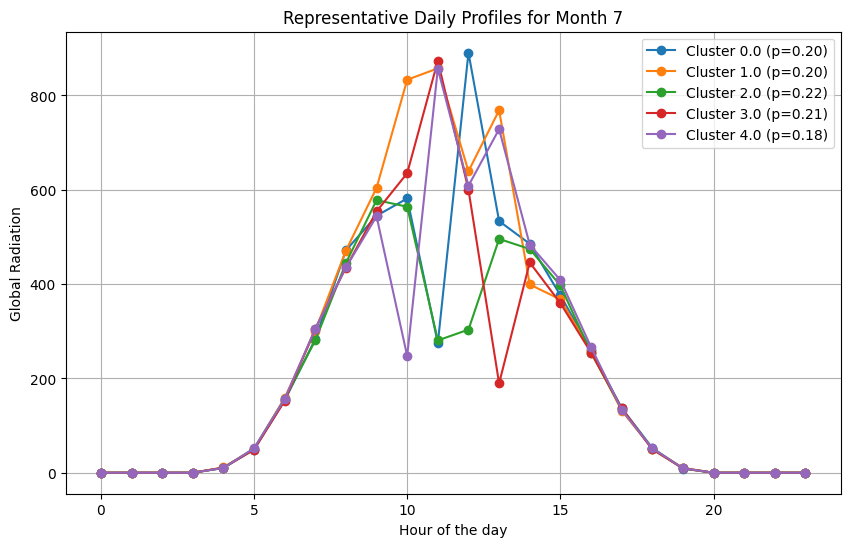

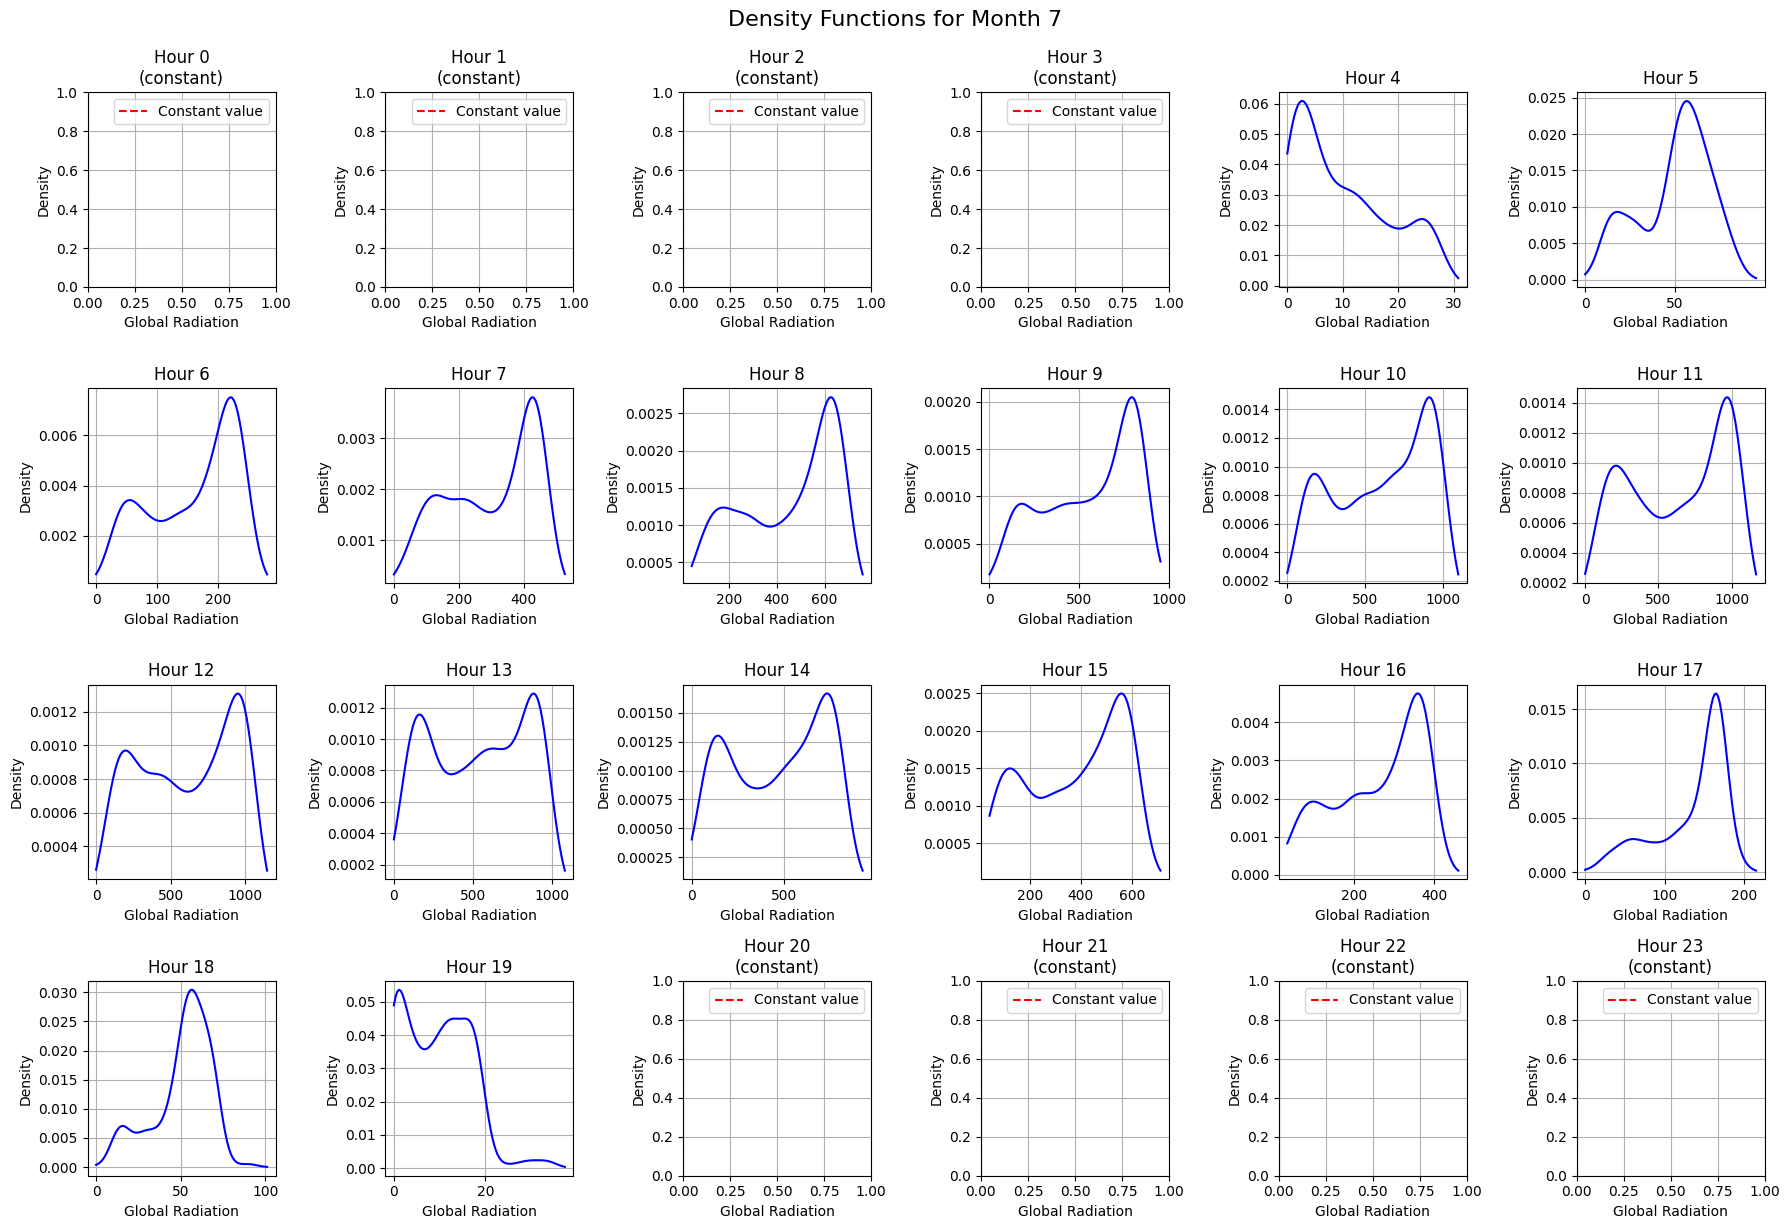

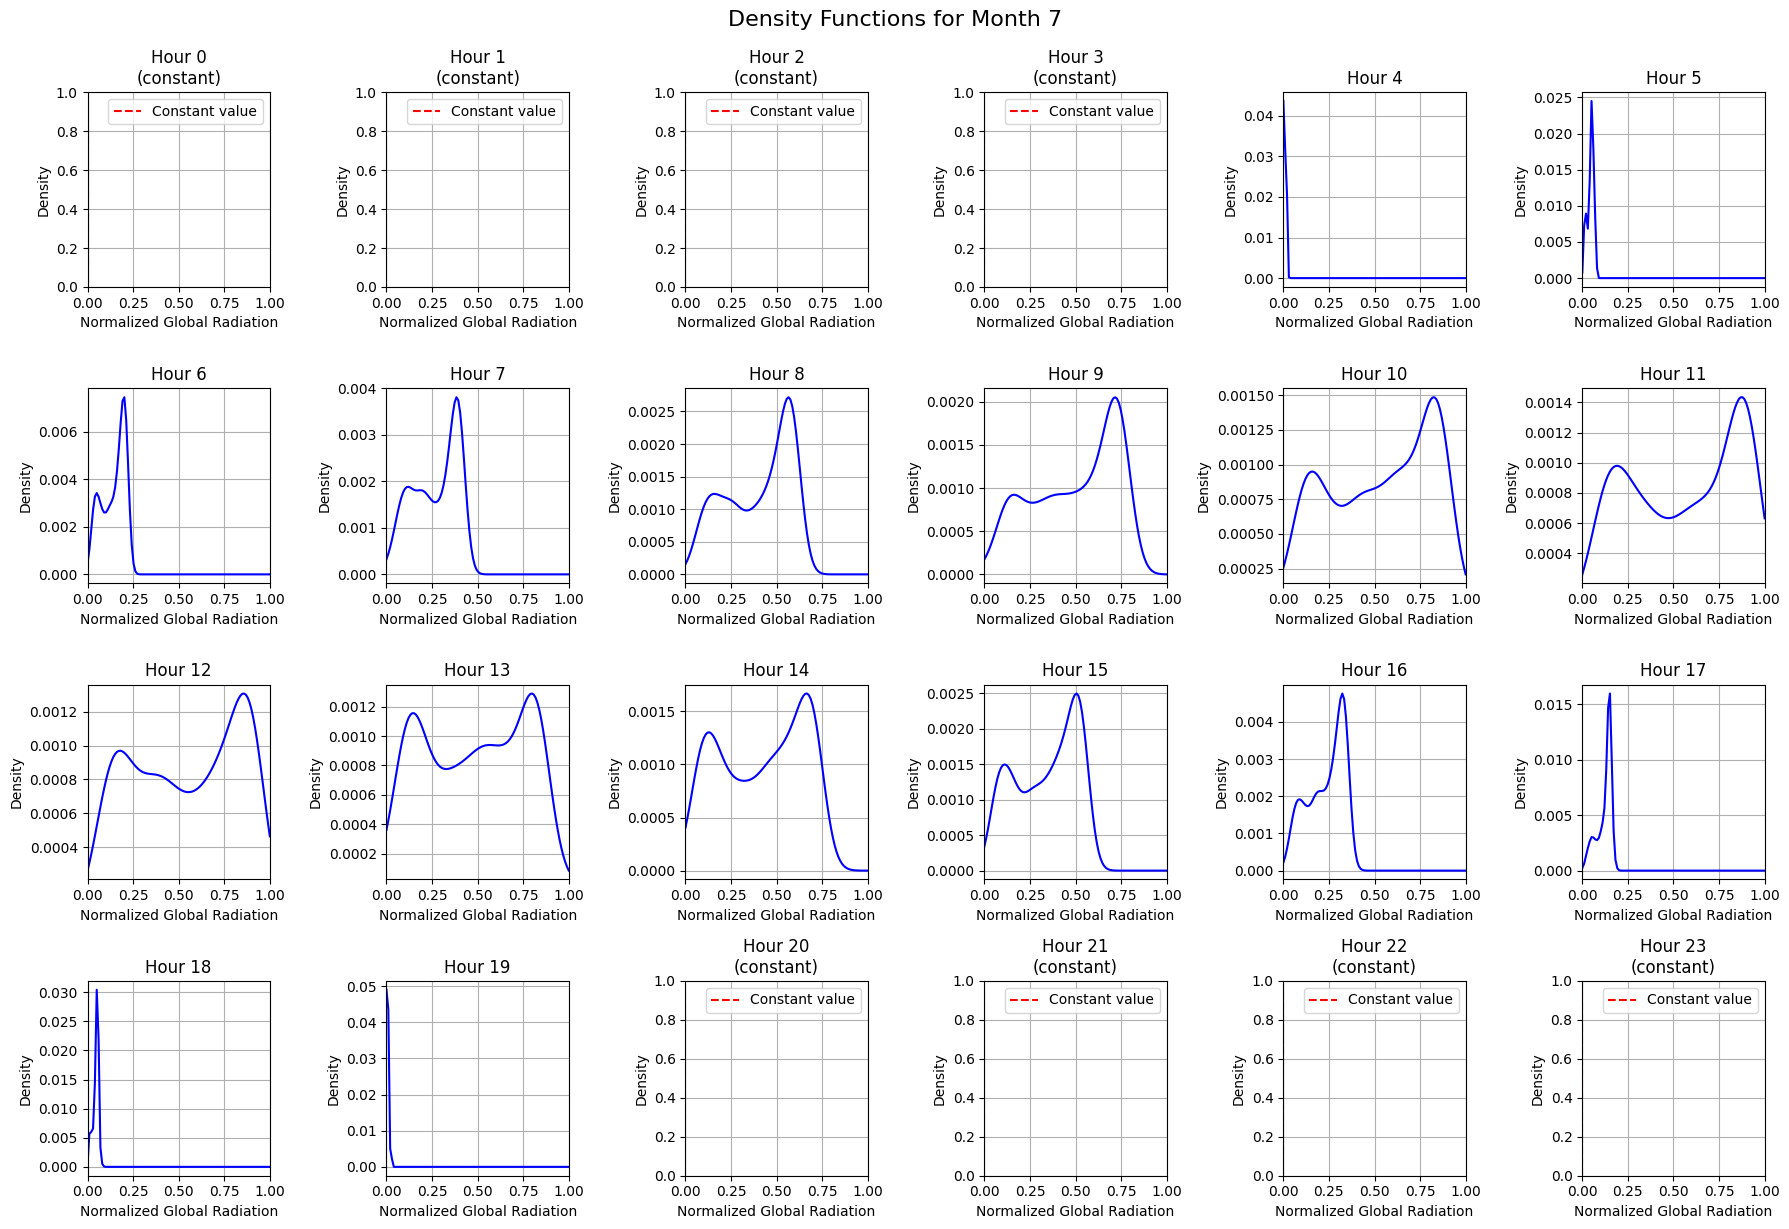

In [20]:
def main():
    # Parameters
    dataset_path = 'Solar_Timeseries_2005_2023.csv'
    clusters_per_month = 5
    n_simulations = 1000
    example_month = 7

    # 1. Read and preprocess dataset
    df = read_and_prepare_dataset(dataset_path)

    # 2. Compute the empirical CDF for each month and hour
    cdf_lookup, months = compute_cdf_lookup(df)

    # 3. Monte Carlo simulation and scenario reduction
    rep_profiles = []  # List to store representative profiles
    for month in months:
        print(f"Simulating and clustering for month {month} ...")
        simulated_profiles = simulate_daily_profile(month, cdf_lookup, n_simulations)
        #OUTPUT: shape ("n_simulations", 24) for month "month"
        # Skip if there is not enough data
        if simulated_profiles.shape[0] < clusters_per_month:
            continue
        clusters = cluster_profiles(simulated_profiles, clusters_per_month)
        for cl in clusters:
            cl['month'] = month
            rep_profiles.append(cl)

    # 4. Save representative profiles
    rep_df = save_representative_profiles(rep_profiles)

    # 5. Visualize representative profiles for an example month
    plot_profiles_for_month(rep_df, example_month)

    # 6. Visualize density functions for each hour of the example month
    plot_density_functions_for_month(df, example_month)

    # 7. Visualize density functions for each hour of the example month with normalized x-axis
    plot_density_functions_for_month_normalized(df, example_month)


if __name__ == "__main__":
    main()